### `RandomForest` Modelling on Hyperglycemic data with imbalanced labelling

In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

SEED=90089

In [2]:
# Read Data
patient_df = pd.read_csv('../data/hyperglycemic_patients_w_bin_categories.csv', index_col=0)

# print detail summary
print("Dataframe shape:   ", patient_df.shape)
print("Dataframe Features:", patient_df.columns)
patient_df.head()

Dataframe shape:    (13243, 27)
Dataframe Features: Index(['glucose_max', 'anchor_age', 'dod', 'gender', 'dbp_mean', 'sbp_mean',
       'glucose_mean', 'heart_rate_mean', 'spo2_mean', 'resp_rate_mean',
       'temperature_mean', 'apsiii', 'glucose_score', 'los', 'avg_bmi_value',
       'avg_sofa', 'admission_type', 'label', 'AMBULATORY OBSERVATION',
       'DIRECT EMER.', 'DIRECT OBSERVATION', 'ELECTIVE', 'EU OBSERVATION',
       'EW EMER.', 'OBSERVATION ADMIT', 'SURGICAL SAME DAY ADMISSION',
       'URGENT'],
      dtype='object')


,glucose_max,anchor_age,dod,gender,dbp_mean,sbp_mean,glucose_mean,heart_rate_mean,spo2_mean,resp_rate_mean,...,label,AMBULATORY OBSERVATION,DIRECT EMER.,DIRECT OBSERVATION,ELECTIVE,EU OBSERVATION,EW EMER.,OBSERVATION ADMIT,SURGICAL SAME DAY ADMISSION,URGENT
0,277.0,36,0,0,64.320000,112.880000,221.272727,101.800000,1.963788,1.239203,...,0,0,0,0,0,0,0,1,0,0
1,259.0,19,1,1,49.300000,74.200000,259.000000,89.750000,1.845098,1.420506,...,0,0,0,0,0,0,1,0,0,0
2,406.0,24,0,0,57.333333,92.848485,292.000000,86.631579,1.983004,1.184393,...,2,0,0,0,0,0,1,0,0,0
3,398.0,31,0,0,78.600000,133.800000,285.000000,100.826087,1.955709,1.400951,...,0,0,0,0,0,0,1,0,0,0
4,487.0,34,0,1,107.062500,164.437500,235.777778,77.000000,1.996731,1.398870,...,2,0,0,0,0,0,0,0,0,1


In [3]:
print("Null value in Feature set summary:\n",patient_df.isnull().sum())

Null value in Feature set summary:
 glucose_max                    0
anchor_age                     0
dod                            0
gender                         0
dbp_mean                       0
sbp_mean                       0
glucose_mean                   0
heart_rate_mean                0
spo2_mean                      0
resp_rate_mean                 0
temperature_mean               0
apsiii                         0
glucose_score                  0
los                            0
avg_bmi_value                  0
avg_sofa                       0
admission_type                 0
label                          0
AMBULATORY OBSERVATION         0
DIRECT EMER.                   0
DIRECT OBSERVATION             0
ELECTIVE                       0
EU OBSERVATION                 0
EW EMER.                       0
OBSERVATION ADMIT              0
SURGICAL SAME DAY ADMISSION    0
URGENT                         0
dtype: int64


In [4]:
print("Label Distirbution:\n", patient_df['label'].value_counts())

Label Distirbution:
 0    8229
1    3178
2    1836
Name: label, dtype: int64


In [3]:
numerical_features = ['glucose_max', 'anchor_age', 'dbp_mean', 'sbp_mean',
       'glucose_mean', 'heart_rate_mean', 'spo2_mean', 'resp_rate_mean',
       'temperature_mean', 'apsiii', 'glucose_score', 'avg_sofa', 'avg_bmi_value']


# Standardized variable for consistent measurement across numerical values
scaler = StandardScaler()
X_std = scaler.fit_transform(patient_df[numerical_features])

# Interpolate categorical variables
X_cat = patient_df[['gender', 'AMBULATORY OBSERVATION',
       'DIRECT EMER.', 'DIRECT OBSERVATION', 'ELECTIVE', 'EU OBSERVATION',
       'EW EMER.', 'OBSERVATION ADMIT', 'SURGICAL SAME DAY ADMISSION',
       'URGENT']]


X = np.concatenate([X_std, X_cat.to_numpy()], axis=1)
y = patient_df["label"]
print("X Standardized data Shape: ", X_std.shape)
print("X Categorical data shape:  ", X_cat.shape)
print("X, y shape:                ", X.shape, y.shape)

X Standardized data Shape:  (13243, 13)
X Categorical data shape:   (13243, 10)
X, y shape:                 (13243, 23) (13243,)


In [4]:
# Split data based on training 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=SEED)
print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (10594, 23) (10594,)
Test data shape: (2649, 23) (2649,)


### Hyperparameter Tunning on `RandomForest`

In [12]:
param_grid = {
 'bootstrap'        : [True, False],
 'max_depth'        : [20, 60, 100],
 'min_samples_leaf' : [1, 4],
 'max_features'     : ['sqrt', 'log2'],
 'min_samples_split': [2, 5, 10],
 'n_estimators'     : [50, 100, 200]}
rf_model = RandomForestClassifier(random_state=SEED)

In [13]:
# disable deprecation warnings
warnings.filterwarnings('ignore')

In [14]:
random_grid_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid, 
                                    n_iter=100, cv=5, n_jobs=7)
random_grid_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=90089),
                   n_iter=100, n_jobs=7,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 60, 100],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]})

In [15]:
print("----         Results from Grid Search           ---")
print("\n The best estimator across ALL searched params:\n", random_grid_rf.best_estimator_)

## Removed scoring due to combinations yielding NaN results
#  print("\n The best score across ALL searched params:\n", grid_RF.best_score_) 
print("\n The best parameters across ALL searched params:\n", random_grid_rf.best_params_)

----         Results from Grid Search           ---

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=20, max_features='log2', min_samples_split=5,
                       n_estimators=200, random_state=90089)

 The best parameters across ALL searched params:
 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}


In [12]:
# Instantiate RandomForest classifierr
rf_clf = RandomForestClassifier(n_estimators=200, 
                                min_samples_split=5,
                                min_samples_leaf=1,
                                max_features='log2',
                                max_depth=20,
                                random_state=SEED,
                                n_jobs=4)

### Evaluation on `RandomForest` with imbalance data

In [13]:
rf_clf.fit(X_train, y_train)
print("Model Accuracy based on Testing dataset:", rf_clf.score(X_test, y_test))

Model Accuracy based on Testing dataset: 0.6301675977653631


In [7]:
print("RF Feature Importance:", rf_clf.feature_importances_)

y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

RF Feature Importance: [6.89223596e-02 6.16035853e-02 7.16587604e-02 7.49963910e-02
 7.08871339e-02 7.38057183e-02 8.18194724e-02 7.58120915e-02
 8.66880119e-02 1.24491889e-01 7.39840218e-03 9.80808780e-02
 5.68047169e-02 1.07537555e-02 3.53601370e-06 4.91904140e-03
 7.00837821e-05 2.61781076e-03 7.70664698e-05 9.10202218e-03
 6.80496700e-03 4.18737488e-03 8.49493140e-03]
              precision    recall  f1-score   support

           0       0.69      0.94      0.80      1644
           1       0.38      0.11      0.17       635
           2       0.46      0.28      0.35       370

    accuracy                           0.65      2649
   macro avg       0.51      0.44      0.44      2649
weighted avg       0.58      0.65      0.58      2649



### AUC Computations

In [8]:
N_CLASSES = len(np.unique(patient_df.label))
y_train_encoded = label_binarize(y_train, classes=[0, 1, 2])
y_test_encoded = label_binarize(y_test, classes=[0, 1, 2])

rf_clf = RandomForestClassifier(n_estimators=200, 
                                min_samples_split=5,
                                min_samples_leaf=1,
                                max_features='log2',
                                max_depth=20,
                                random_state=SEED,
                                n_jobs=4)

ovr_clf = OneVsRestClassifier(rf_clf, n_jobs=2)

y_score_encoded = ovr_clf.fit(X_train, y_train_encoded).predict_proba(X_test)

# false-positive, and true-positive rate
fp_rate, tp_rate = dict(), dict()
roc_auc = dict()

for c in range(N_CLASSES):
    fp_rate[c], tp_rate[c], _ = roc_curve(y_test_encoded[:, c], y_score_encoded[:, c])
    roc_auc[c] = auc(fp_rate[c], tp_rate[c])

# compute micro-average ROC curve & area in each area.

fp_rate['micro'], tp_rate['micro'], _ = roc_curve(y_test_encoded.ravel(), y_score_encoded.ravel())
roc_auc["micro"] = auc(fp_rate['micro'], tp_rate['micro'])

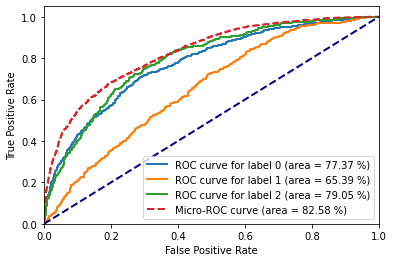

In [9]:
plt.figure()
lw = 2

for c in range(N_CLASSES):
    plt.plot(
        fp_rate[c],
        tp_rate[c],
        lw=lw,
        label="ROC curve for label %0.f (area = %0.2f %%)" %(c, roc_auc[c]*100),
    )

plt.plot(
        fp_rate['micro'],
        tp_rate['micro'],
        linestyle='dashed',
        lw=lw,
        label="Micro-ROC curve (area = %0.2f %%)" %(roc_auc['micro']*100),
    )

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = ovr_clf.predict_proba(X_test)
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(N_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_test_encoded[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_encoded[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_encoded.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_encoded, y_score, average="micro")

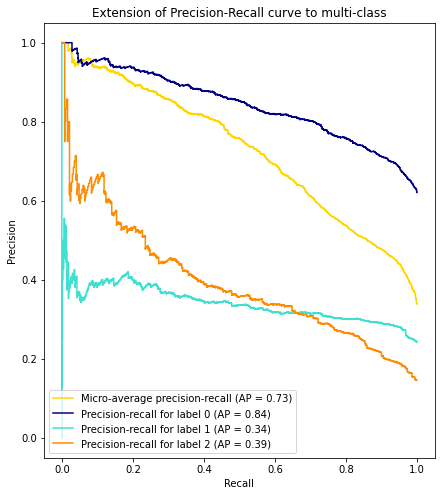

In [22]:
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle

colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
_, ax = plt.subplots(figsize=(7, 8))
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
ax.set_title("Extension of Precision-Recall curve to multi-class")
for i, color in zip(range(N_CLASSES), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for label {i}", color=color)